In [1]:
import numpy as np
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from helper_funcs import get_data_loaders, get_model, train_model, evaluate
from Transformers import ProjectionHead
plt.style.use('default')
import torch.optim as optim
import json
from sklearn.model_selection import StratifiedShuffleSplit
from Transformers import MedicalTimeSeriesDatasetTuple, collate_fn
from torch.utils.data import WeightedRandomSampler, DataLoader



In [2]:
config = {
    "model_type": "contrast",  # Choose 'time_grid', 'tuple', "contrast", linear_probe
    "scaler_name": "MinMaxScaler", # Name of the scaler used

    "seed": 42,
    "device": "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu",
    "epochs": 30, # Adjust as needed
    "batch_size": 64,
    "learning_rate": 1e-4,
    "weight_decay": 1e-5,
    "patience": 8, # For early stopping based on validation performance
    "optimizer": "adam", # Choose 'adam', 'sgd', or 'adamw'
    "loss_function": "bce", # Choose 'bce', 'focal', or 'mse'

    # Paths (MODIFY THESE)
    "data_dir": "data", # Directory containing train/val/test data
    "output_dir": "data/model_outputs", # Directory to save models and results

    # Model Specific Hyperparameters (adjust based on model_type and tuning)
    # Grid Transformer
    "grid_d_model": 128,
    "grid_nhead": 4,
    "grid_num_layers": 2,
    "grid_dropout": 0.2,
    "grid_feature_dim": 41, # Should match your data

    # Tuple Transformer
    "tuple_d_model": 128,
    "tuple_nhead": 8,
    "tuple_num_encoder_layers": 3,
    "tuple_dim_feedforward": 256, # Typically 2-4x d_model
    "tuple_dropout": 0.2,
    "tuple_num_modalities": 41, # 40 variables + 1 for padding (if PAD_INDEX_Z=0) Adjust if needed!
    "PAD_INDEX_Z": 0, # Padding index for time and value features
    "tuple_modality_emb_dim": 64,
    "tuple_max_seq_len": 768, # From transformers.py or defined here

    # Contrastive Learning
    "proj_dim": 128
    }

In [4]:

# --- Add this near the top of your script ---
def set_seed(seed_value=42):
    """Sets the seed for reproducibility in PyTorch, NumPy, and Python."""
    random.seed(seed_value)  # Python random module
    np.random.seed(seed_value) # Numpy module
    torch.manual_seed(seed_value) # PyTorch CPU seeding

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # if you are using multi-GPU.
        # Configure CuDNN for deterministic operations
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        # Optional: Newer PyTorch versions might require this for full determinism
        # Note: This can sometimes throw errors if a deterministic implementation isn't available
        # try:
        #     torch.use_deterministic_algorithms(True)
        # except Exception as e:
        #     print(f"Warning: Could not enable deterministic algorithms: {e}")
        # Optional: Sometimes needed for deterministic matrix multiplication
        # os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

    print(f"Seed set globally to {seed_value}")



# --- Call this function very early in your script ---
seed = config["seed"]
set_seed(seed)


Seed set globally to 42


In [5]:
def info_nce_loss(embeddings1, embeddings2, temperature = 0.2):
    """
    embeddings1: Tensor of shape (batch_size, proj_dim) for view 1
    embeddings2: Tensor of shape (batch_size, proj_dim) for view 2
    """
    batch_size = embeddings1.shape[0]

    # Normalize the embeddings
    embeddings1 = nn.functional.normalize(embeddings1, dim=1)
    embeddings2 = nn.functional.normalize(embeddings2, dim=1)

    similarity_matrix = torch.matmul(embeddings1, embeddings2.T) / temperature # shape (batch_size, batch_size)
    labels = torch.arange(batch_size, device=embeddings1.device)

    loss1 = nn.functional.cross_entropy(similarity_matrix, labels)
    loss2 = nn.functional.cross_entropy(similarity_matrix.T, labels)
    loss = (loss1 + loss2) / 2.0

    return loss

In [6]:
def train_contrastive(encoder, projection_head, dataloader, optimizer, device):
    encoder.train()
    projection_head.train()
    total_loss = 0.0
    for batch in tqdm(dataloader, desc="Training"):
        (t_seq1, z_seq1, v_seq1, attn_mask1), (t_seq2, z_seq2, v_seq2, attn_mask2), _ = batch
        t_seq1, z_seq1, v_seq1, attn_mask1 = t_seq1.to(device), z_seq1.to(device), v_seq1.to(device), attn_mask1.to(device)
        t_seq2, z_seq2, v_seq2, attn_mask2 = t_seq2.to(device), z_seq2.to(device), v_seq2.to(device), attn_mask2.to(device)
        optimizer.zero_grad()
        rep1 = encoder.get_representation(t_seq1, z_seq1, v_seq1, attn_mask1)
        rep2 = encoder.get_representation(t_seq2, z_seq2, v_seq2, attn_mask2)
        proj1 = projection_head(rep1)
        proj2 = projection_head(rep2)
        loss = info_nce_loss(proj1, proj2, temperature=0.2)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)





# --------------------------

In [7]:
contrastive_loader,_, _ = get_data_loaders(config) 



device = config["device"]
encoder = get_model(config)

encoder.to(device)

projection_head = ProjectionHead(config["tuple_d_model"], config["proj_dim"])
projection_head.to(device)
projection_head = ProjectionHead(config["tuple_d_model"], config["proj_dim"])
projection_head.to(device)

optimizer_pretrain = torch.optim.AdamW(list(encoder.parameters()) + list(projection_head.parameters()), lr=config["learning_rate"], weight_decay=config["weight_decay"])

for epoch in range(config["epochs"]):
    print(f"\nEpoch {epoch+1}/{config['epochs']}")

    train_loss = train_contrastive(encoder,projection_head, contrastive_loader, optimizer_pretrain, device)
    print(f"Epoch {epoch+1}/{config['epochs']}, Loss: {train_loss:.4f}")

# Save the encoder and projection head

model_name = f"V3_contrastive_encoder_model_epoch_{config['epochs']}.pth"
torch.save(encoder.state_dict(), f"{config['output_dir']}/{model_name}.pth")
torch.save(projection_head.state_dict(), f"{config['output_dir']}/{model_name}_projection_head.pth")
print(f"Model saved as {model_name}")
# save config
with open(f"{config['output_dir']}/config_{model_name}.json", "w") as f:
    json.dump(config, f, indent=4)



Model (contrast) created and moved to cuda.

Epoch 1/30


Training: 100%|██████████| 63/63 [00:29<00:00,  2.13it/s]


Epoch 1/30, Loss: 2.3025

Epoch 2/30


Training: 100%|██████████| 63/63 [00:29<00:00,  2.15it/s]


Epoch 2/30, Loss: 1.7857

Epoch 3/30


Training: 100%|██████████| 63/63 [00:29<00:00,  2.15it/s]


Epoch 3/30, Loss: 1.6061

Epoch 4/30


Training: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s]


Epoch 4/30, Loss: 1.4978

Epoch 5/30


Training: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s]


Epoch 5/30, Loss: 1.4302

Epoch 6/30


Training: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s]


Epoch 6/30, Loss: 1.3844

Epoch 7/30


Training: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s]


Epoch 7/30, Loss: 1.3411

Epoch 8/30


Training: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s]


Epoch 8/30, Loss: 1.3020

Epoch 9/30


Training: 100%|██████████| 63/63 [00:29<00:00,  2.15it/s]


Epoch 9/30, Loss: 1.2791

Epoch 10/30


Training: 100%|██████████| 63/63 [00:29<00:00,  2.15it/s]


Epoch 10/30, Loss: 1.2601

Epoch 11/30


Training: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s]


Epoch 11/30, Loss: 1.2386

Epoch 12/30


Training: 100%|██████████| 63/63 [00:29<00:00,  2.15it/s]


Epoch 12/30, Loss: 1.2301

Epoch 13/30


Training: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s]


Epoch 13/30, Loss: 1.2009

Epoch 14/30


Training: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s]


Epoch 14/30, Loss: 1.1967

Epoch 15/30


Training: 100%|██████████| 63/63 [00:29<00:00,  2.15it/s]


Epoch 15/30, Loss: 1.1840

Epoch 16/30


Training: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s]


Epoch 16/30, Loss: 1.1760

Epoch 17/30


Training: 100%|██████████| 63/63 [00:29<00:00,  2.15it/s]


Epoch 17/30, Loss: 1.1558

Epoch 18/30


Training: 100%|██████████| 63/63 [00:29<00:00,  2.15it/s]


Epoch 18/30, Loss: 1.1463

Epoch 19/30


Training: 100%|██████████| 63/63 [00:29<00:00,  2.15it/s]


Epoch 19/30, Loss: 1.1406

Epoch 20/30


Training: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s]


Epoch 20/30, Loss: 1.1302

Epoch 21/30


Training: 100%|██████████| 63/63 [00:29<00:00,  2.15it/s]


Epoch 21/30, Loss: 1.1241

Epoch 22/30


Training: 100%|██████████| 63/63 [00:29<00:00,  2.15it/s]


Epoch 25/30, Loss: 1.0945

Epoch 26/30


Training: 100%|██████████| 63/63 [00:29<00:00,  2.15it/s]


Epoch 26/30, Loss: 1.0848

Epoch 27/30


Training: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s]


Epoch 27/30, Loss: 1.0880

Epoch 28/30


Training: 100%|██████████| 63/63 [00:29<00:00,  2.15it/s]


Epoch 28/30, Loss: 1.0726

Epoch 29/30


Training: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s]


Epoch 29/30, Loss: 1.0647

Epoch 30/30


Training: 100%|██████████| 63/63 [00:29<00:00,  2.15it/s]

Epoch 30/30, Loss: 1.0743
Model saved as V3_contrastive_encoder_model_epoch_30.pth


In [8]:
from sklearn.metrics import  confusion_matrix, roc_auc_score, average_precision_score

def evaluate(model, dataloader, criterion, device, model_type, linear_probe=None):
    model.eval()
    if linear_probe:
        linear_probe.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            if model_type == "tuple":
                t_seq, z_seq, v_seq, attn_mask, labels = batch
                t_seq, z_seq, v_seq, attn_mask, labels = t_seq.to(device), z_seq.to(device), v_seq.to(device), attn_mask.to(device), labels.to(device)
                logits = model(t_seq, z_seq, v_seq, attn_mask)
                y = labels

                # Store original labels for metrics


            elif model_type == "time_grid":
                x, labels = batch
                x = x.to(device)
                y = labels.to(device)
                logits = model(x)

                # Store original labels for metrics

            elif model_type == "linear_probe":
                t_seq, z_seq, v_seq, attn_mask, labels = batch
                t_seq, z_seq, v_seq, attn_mask, labels = t_seq.to(device), z_seq.to(device), v_seq.to(device), attn_mask.to(device), labels.to(device)
                rep = model.get_representation(t_seq, z_seq, v_seq, attn_mask)
                logits = linear_probe(rep)
                y = labels

            else:
                raise ValueError(f"Unknown model_type: {model_type}")
        
            loss = criterion(logits, y)
            total_loss += loss.item()

            probs = torch.sigmoid(logits).cpu().numpy()
            all_preds.extend(probs.flatten().flatten())
            all_labels.extend(y.cpu().numpy().flatten())

    avg_loss = total_loss / len(dataloader)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    auroc = roc_auc_score(all_labels, all_preds)
    auprc = average_precision_score(all_labels, all_preds)
    confusion_matrix_result = confusion_matrix(all_labels, (all_preds > 0.5).astype(int))
    return avg_loss, auroc, auprc, confusion_matrix_result
 

In [9]:
# Load the encoder and projection head
config["model_type"] = "contrast"
encoder = get_model(config)
encoder.load_state_dict(torch.load(f"{config['output_dir']}/{model_name}.pth"))
encoder.to(device)
projection_head = ProjectionHead(config["tuple_d_model"], config["proj_dim"])
projection_head.load_state_dict(torch.load(f"{config['output_dir']}/{model_name}_projection_head.pth"))
projection_head.to(device)

# freeze the encoder
for param in encoder.parameters():
    param.requires_grad = False

linear_probe = nn.Linear(config["proj_dim"], 1) 
linear_probe.to(device)

optimizer_probe = torch.optim.AdamW(linear_probe.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
criterion = nn.BCEWithLogitsLoss()
config["model_type"] = "linear_probe" # Set the model type to linear probe for training
# Get the data loaders for training, validation, and testing
train_loader, val_loader, test_loader = get_data_loaders(config)


best_val_auroc = -1.0
epochs_no_improve = 0
best_model_path = os.path.join(config["output_dir"], f"{model_name}_linear_probe.pth")

print("Training Linear Probe...")
for epoch in range(config["epochs"]):
    print(f"\nEpoch {epoch+1}/{config['epochs']}")
    
    train_loss = train_model(encoder, train_loader, criterion, optimizer_probe, device, model_type= config["model_type"],linear_probe=linear_probe)
    print(f"Epoch {epoch+1}/{config['epochs']}, Loss: {train_loss:.4f}")

    val_loss, val_auroc, val_auprc, _ = evaluate(encoder, val_loader, criterion, device, model_type=config["model_type"], linear_probe=linear_probe)
    if val_auroc > best_val_auroc:
            print(f"Validation AuROC improved ({best_val_auroc:.4f} -> {val_auroc:.4f}). Saving model...")
            best_val_auroc = val_auroc
            torch.save(linear_probe.state_dict(), best_model_path)
            epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"Validation AuROC did not improve. ({epochs_no_improve}/{config['patience']})")

    if epochs_no_improve >= config["patience"]:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

Model (contrast) created and moved to cuda.
Tuple Data: Train Patients: 4000, Val Patients: 4000, Test Patients: 4000
Using 41 modalities (including padding index 0
Labels - Train: 4000 (Positive: 554), Val: 4000 (Positive: 568), Test: 4000 (Positive: 585)
DataLoaders created.
Training Linear Probe...

Epoch 1/30


Training:   0%|          | 0/63 [00:00<?, ?it/s]/opt/conda/envs/hodl_jupyter_env/lib/python3.11/site-packages/torch/nn/modules/transformer.py:408: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905971190/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


Epoch 1/30, Loss: 0.6962


Validation AuROC improved (-1.0000 -> 0.4962). Saving model...

Epoch 2/30


Epoch 2/30, Loss: 0.6939


Validation AuROC improved (0.4962 -> 0.5272). Saving model...

Epoch 3/30


Epoch 3/30, Loss: 0.6896


Validation AuROC improved (0.5272 -> 0.5562). Saving model...

Epoch 4/30


Epoch 4/30, Loss: 0.6866


Validation AuROC improved (0.5562 -> 0.5837). Saving model...

Epoch 5/30


Epoch 5/30, Loss: 0.6850


Validation AuROC improved (0.5837 -> 0.6091). Saving model...

Epoch 6/30


Epoch 6/30, Loss: 0.6828


Validation AuROC improved (0.6091 -> 0.6268). Saving model...

Epoch 7/30


Epoch 7/30, Loss: 0.6801


Validation AuROC improved (0.6268 -> 0.6413). Saving model...

Epoch 8/30


Epoch 8/30, Loss: 0.6784


Validation AuROC improved (0.6413 -> 0.6522). Saving model...

Epoch 9/30


Epoch 9/30, Loss: 0.6762


Validation AuROC improved (0.6522 -> 0.6592). Saving model...

Epoch 10/30


Epoch 10/30, Loss: 0.6741


Validation AuROC improved (0.6592 -> 0.6656). Saving model...

Epoch 11/30


Epoch 11/30, Loss: 0.6700


Validation AuROC improved (0.6656 -> 0.6705). Saving model...

Epoch 12/30


Epoch 12/30, Loss: 0.6701


Validation AuROC improved (0.6705 -> 0.6745). Saving model...

Epoch 13/30


Epoch 13/30, Loss: 0.6668


Validation AuROC improved (0.6745 -> 0.6771). Saving model...

Epoch 14/30


Epoch 14/30, Loss: 0.6637


Validation AuROC improved (0.6771 -> 0.6789). Saving model...

Epoch 15/30


Epoch 15/30, Loss: 0.6622


Validation AuROC improved (0.6789 -> 0.6803). Saving model...

Epoch 16/30


Epoch 16/30, Loss: 0.6643


Validation AuROC improved (0.6803 -> 0.6811). Saving model...

Epoch 17/30


Epoch 17/30, Loss: 0.6639


Validation AuROC improved (0.6811 -> 0.6820). Saving model...

Epoch 18/30


Epoch 18/30, Loss: 0.6626


Validation AuROC improved (0.6820 -> 0.6820). Saving model...

Epoch 19/30


Epoch 19/30, Loss: 0.6559


Validation AuROC improved (0.6820 -> 0.6829). Saving model...

Epoch 20/30


Epoch 20/30, Loss: 0.6620


Validation AuROC improved (0.6829 -> 0.6833). Saving model...

Epoch 21/30


Epoch 21/30, Loss: 0.6546


Validation AuROC improved (0.6833 -> 0.6839). Saving model...

Epoch 22/30


Epoch 22/30, Loss: 0.6580


Validation AuROC improved (0.6839 -> 0.6844). Saving model...

Epoch 23/30


Epoch 23/30, Loss: 0.6596


Validation AuROC improved (0.6844 -> 0.6846). Saving model...

Epoch 24/30


Epoch 24/30, Loss: 0.6538


Validation AuROC improved (0.6846 -> 0.6850). Saving model...

Epoch 25/30


Epoch 25/30, Loss: 0.6576


Validation AuROC improved (0.6850 -> 0.6855). Saving model...

Epoch 26/30


Epoch 26/30, Loss: 0.6563


Validation AuROC improved (0.6855 -> 0.6856). Saving model...

Epoch 27/30


Epoch 27/30, Loss: 0.6557


Validation AuROC improved (0.6856 -> 0.6858). Saving model...

Epoch 28/30


Epoch 28/30, Loss: 0.6562


Validation AuROC improved (0.6858 -> 0.6860). Saving model...

Epoch 29/30


Epoch 29/30, Loss: 0.6516


Validation AuROC did not improve. (1/8)

Epoch 30/30


Epoch 30/30, Loss: 0.6537


Validation AuROC did not improve. (2/8)


In [23]:

linear_probe.load_state_dict(torch.load(best_model_path))
print("\n--- Evaluating on Test Set ---")
config["model_type"] = "linear_probe" # Set the model type to linear probe for evaluation
test_loss, test_auroc, test_auprc, cm = evaluate(encoder, test_loader, criterion, config["device"], config["model_type"], linear_probe=linear_probe)
print("\n--- Test Results ---")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test AuROC: {test_auroc:.4f}")
print(f"Test AuPRC: {test_auprc:.4f}")
print(f"Confusion Matrix:\n{cm}")
print("--------------------")
results = {
    "test_loss": test_loss,
    "test_auroc": test_auroc,
    "test_auprc": test_auprc,
    "confusion_matrix": cm.tolist(),  # Convert to list for JSON serialization
}
# Save results to a JSON file
results_path = os.path.join(config["output_dir"], f"results_{model_name}_linear_probe.json")
with open(results_path, "w") as f:
    json.dump(results, f, indent=4)


--- Evaluating on Test Set ---



--- Test Results ---
Test Loss: 0.6560
Test AuROC: 0.6890
Test AuPRC: 0.2544
Confusion Matrix:
[[2054 1361]
 [ 173  412]]
--------------------


## 3.2. Simulating sparse labels

In [25]:
def get_stratified_subset_indices(labels, subset_size, random_state=None):
    """
    Get stratified subset indices from the labels.
    
    Args:
        labels (array-like): The labels for stratification.
        subset_size (int): The size of the subset to sample.
        random_state (int, optional): Random state for reproducibility.
        
    Returns:
        list: Indices of the sampled subset.
    """
    dummy_features = np.zeros((len(labels)))  # Dummy features for stratification
    sss = StratifiedShuffleSplit(n_splits=1, train_size=subset_size, random_state=random_state)

    for train_index,_  in sss.split(dummy_features, labels):
        return train_index

In [26]:
# Load data
seed = config["seed"]
data_path = config["data_dir"]

y_train = np.load(os.path.join(data_path, 'outcomes_sorted_set-a.npy'), allow_pickle=True)
y_val = np.load(os.path.join(data_path, 'outcomes_sorted_set-b.npy'),allow_pickle=True)
y_test = np.load(os.path.join(data_path, 'outcomes_sorted_set-c.npy'), allow_pickle=True)

scaler_name = config["scaler_name"]
data_format = "tuple" # or "tuple" depending on your data format
X_train = np.load(os.path.join(data_path,f"{data_format}_processed_{scaler_name}_set-a.npy"), allow_pickle=True)
X_val = np.load(os.path.join(data_path,f"{data_format}_processed_{scaler_name}_set-b.npy"), allow_pickle=True)
X_test = np.load(os.path.join(data_path,f"{data_format}_processed_{scaler_name}_set-c.npy"), allow_pickle=True)

In [27]:
# Train Tuple Transformer on 100, 500 and 1000 subset samples
subset_sizes = ["100", "500", "1000"]

idx_100 = get_stratified_subset_indices(y_train, 100, random_state=seed)
idx_500 = get_stratified_subset_indices(y_train, 500, random_state=seed)
idx_1000 = get_stratified_subset_indices(y_train, 1000, random_state=seed)

y_train_100 = y_train[idx_100]
X_train_100 = X_train[idx_100]

y_train_500 = y_train[idx_500]
X_train_500 = X_train[idx_500]

y_train_1000 = y_train[idx_1000]
X_train_1000 = X_train[idx_1000]

subsets = {
    "100": (X_train_100, y_train_100),
    "500": (X_train_500, y_train_500),
    "1000": (X_train_1000, y_train_1000)
}

In [28]:
val_dataset = MedicalTimeSeriesDatasetTuple(X_val, y_val, max_seq_len=config["tuple_max_seq_len"])
test_dataset = MedicalTimeSeriesDatasetTuple(X_test, y_test, max_seq_len=config["tuple_max_seq_len"])
collate_func = collate_fn # Use the custom collate_fn

train_loaders = {}

for size, (X_train_subset, y_train_subset) in subsets.items():
    print(f"Subset size: {size}")

    tmp_train_dataset = MedicalTimeSeriesDatasetTuple(X_train_subset, 
                                                      y_train_subset, 
                                                      max_seq_len=config["tuple_max_seq_len"])

    class_counts = np.bincount(y_train_subset.astype(int))
    class_weights = 1. / class_counts
    sample_weights = np.array([class_weights[int(t)] for t in y_train_subset])
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

    train_loader = DataLoader(tmp_train_dataset, batch_size=config["batch_size"], sampler=sampler, collate_fn=collate_func)
    train_loaders[size] = train_loader

val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False, collate_fn=collate_func)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, collate_fn=collate_func)
    
    

Subset size: 100
Subset size: 500
Subset size: 1000


In [51]:
config["model_type"] = "tuple" # Set the model type to tuple for training
device = config["device"]

for size, train_loader in train_loaders.items():
    print(f"Training Tuple Transformer on subset size: {size}")

    # Initialize the model
    model = get_model(config)
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=config["patience"])

    # 3. Training Loop
    best_val_auroc = -1.0
    epochs_no_improve = 0


    model_name = f"tuple_transformer_{size}_{config['epochs']}.pth"
    best_model_path = os.path.join(config["output_dir"], f"{model_name}.pth")
    config_file_path = os.path.join(config["output_dir"], f"config_{model_name}.json")
    with open(config_file_path, 'w') as f:
        json.dump(config, f, indent=4)


    # Train the model
    for epoch in range(config["epochs"]):
        print(f"\nEpoch {epoch+1}/{config['epochs']}")

        train_loss = train_model(model, train_loader, criterion, optimizer, config["device"], config["model_type"])
        val_loss, val_auroc, val_auprc, _ = evaluate(model, val_loader, criterion, config["device"], config["model_type"])

        scheduler.step(val_auroc)

        if val_auroc > best_val_auroc:
            print(f"Validation AuROC improved ({best_val_auroc:.4f} -> {val_auroc:.4f}). Saving model...")
            best_val_auroc = val_auroc
            torch.save(model.state_dict(), best_model_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"Validation AuROC did not improve. ({epochs_no_improve}/{config['patience']})")

        if epochs_no_improve >= config["patience"]:
                print(f"Early stopping triggered after {epoch + 1} epochs.")
                break
        
    # 4. Load Best Model and Evaluate on Test Set
    print("\n--- Loading Best Model for Testing ---")
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path, map_location=config["device"]))

        print("\n--- Evaluating on Test Set ---")
        test_loss, test_auroc, test_auprc, cm = evaluate(model, test_loader, criterion, config["device"], config["model_type"])
        print("\n--- Test Results ---")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test AuROC: {test_auroc:.4f}")
        print(f"Test AuPRC: {test_auprc:.4f}")
        print(f"Confusion Matrix:\n{cm}")
        print("--------------------")
        results = {
            "Test Loss": test_loss,
            "Test AuROC": test_auroc,
            "Test AuPRC": test_auprc,
            "Confusion Matrix": cm.tolist()  # Convert to list for JSON serialization
        }
        results_file_path = os.path.join(config["output_dir"], f"results_{model_name}.json")
        with open(results_file_path, 'w') as f:
            json.dump(results, f, indent=4)
    else:
        print(f"Best model not found at {best_model_path}. Skipping evaluation.")
        


                

Training Tuple Transformer on subset size: 100
Model (tuple) created and moved to cuda.

Epoch 1/30


Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]    /opt/conda/envs/hodl_jupyter_env/lib/python3.11/site-packages/torch/nn/modules/transformer.py:408: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905971190/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


Validation AuROC improved (-1.0000 -> 0.5393). Saving model...

Epoch 2/30


Validation AuROC improved (0.5393 -> 0.5539). Saving model...

Epoch 3/30


Validation AuROC improved (0.5539 -> 0.5787). Saving model...

Epoch 4/30


Validation AuROC improved (0.5787 -> 0.5889). Saving model...

Epoch 5/30


Validation AuROC improved (0.5889 -> 0.6068). Saving model...

Epoch 6/30


Validation AuROC improved (0.6068 -> 0.6213). Saving model...

Epoch 7/30


Validation AuROC improved (0.6213 -> 0.6364). Saving model...

Epoch 8/30


Validation AuROC improved (0.6364 -> 0.6385). Saving model...

Epoch 9/30


Validation AuROC did not improve. (1/8)

Epoch 10/30


Validation AuROC did not improve. (2/8)

Epoch 11/30


Validation AuROC did not improve. (3/8)

Epoch 12/30


Validation AuROC did not improve. (4/8)

Epoch 13/30


Validation AuROC did not improve. (5/8)

Epoch 14/30


Validation AuROC did not improve. (6/8)

Epoch 15/30


Validation AuROC did not improve. (7/8)

Epoch 16/30


Validation AuROC improved (0.6385 -> 0.6396). Saving model...

Epoch 17/30


Validation AuROC improved (0.6396 -> 0.6424). Saving model...

Epoch 18/30


Validation AuROC improved (0.6424 -> 0.6439). Saving model...

Epoch 19/30


Validation AuROC improved (0.6439 -> 0.6468). Saving model...

Epoch 20/30


Validation AuROC improved (0.6468 -> 0.6470). Saving model...

Epoch 21/30


Validation AuROC improved (0.6470 -> 0.6471). Saving model...

Epoch 22/30


Validation AuROC improved (0.6471 -> 0.6474). Saving model...

Epoch 23/30


Validation AuROC improved (0.6474 -> 0.6477). Saving model...

Epoch 24/30


Validation AuROC improved (0.6477 -> 0.6479). Saving model...

Epoch 25/30


Validation AuROC improved (0.6479 -> 0.6480). Saving model...

Epoch 26/30


Validation AuROC improved (0.6480 -> 0.6480). Saving model...

Epoch 27/30


Validation AuROC improved (0.6480 -> 0.6480). Saving model...

Epoch 28/30


Validation AuROC improved (0.6480 -> 0.6480). Saving model...

Epoch 29/30


Validation AuROC did not improve. (1/8)

Epoch 30/30


Validation AuROC did not improve. (2/8)

--- Loading Best Model for Testing ---

--- Evaluating on Test Set ---



--- Test Results ---
Test Loss: 0.6764
Test AuROC: 0.6487
Test AuPRC: 0.2079
Confusion Matrix:
[[1460 1955]
 [ 106  479]]
--------------------
Training Tuple Transformer on subset size: 500
Model (tuple) created and moved to cuda.

Epoch 1/30


Validation AuROC improved (-1.0000 -> 0.5943). Saving model...

Epoch 2/30


Validation AuROC improved (0.5943 -> 0.6106). Saving model...

Epoch 3/30


Validation AuROC did not improve. (1/8)

Epoch 4/30


Validation AuROC improved (0.6106 -> 0.6393). Saving model...

Epoch 5/30


Validation AuROC did not improve. (1/8)

Epoch 6/30


Validation AuROC improved (0.6393 -> 0.6450). Saving model...

Epoch 7/30


Validation AuROC improved (0.6450 -> 0.6484). Saving model...

Epoch 8/30


Validation AuROC did not improve. (1/8)

Epoch 9/30


Validation AuROC improved (0.6484 -> 0.6501). Saving model...

Epoch 10/30


Validation AuROC did not improve. (1/8)

Epoch 11/30


Validation AuROC did not improve. (2/8)

Epoch 12/30


Validation AuROC did not improve. (3/8)

Epoch 13/30


Validation AuROC did not improve. (4/8)

Epoch 14/30


Validation AuROC did not improve. (5/8)

Epoch 15/30


Validation AuROC did not improve. (6/8)

Epoch 16/30


Validation AuROC did not improve. (7/8)

Epoch 17/30


Validation AuROC did not improve. (8/8)
Early stopping triggered after 17 epochs.

--- Loading Best Model for Testing ---

--- Evaluating on Test Set ---



--- Test Results ---
Test Loss: 0.6400
Test AuROC: 0.6625
Test AuPRC: 0.2355
Confusion Matrix:
[[2064 1351]
 [ 198  387]]
--------------------
Training Tuple Transformer on subset size: 1000
Model (tuple) created and moved to cuda.

Epoch 1/30


Validation AuROC improved (-1.0000 -> 0.6316). Saving model...

Epoch 2/30


Validation AuROC did not improve. (1/8)

Epoch 3/30


Validation AuROC improved (0.6316 -> 0.6496). Saving model...

Epoch 4/30


Validation AuROC improved (0.6496 -> 0.6609). Saving model...

Epoch 5/30


Validation AuROC improved (0.6609 -> 0.6752). Saving model...

Epoch 6/30


Validation AuROC improved (0.6752 -> 0.6895). Saving model...

Epoch 7/30


Validation AuROC did not improve. (1/8)

Epoch 8/30


Validation AuROC did not improve. (2/8)

Epoch 9/30


Validation AuROC did not improve. (3/8)

Epoch 10/30


Validation AuROC did not improve. (4/8)

Epoch 11/30


Validation AuROC improved (0.6895 -> 0.6917). Saving model...

Epoch 12/30


Validation AuROC did not improve. (1/8)

Epoch 13/30


Validation AuROC improved (0.6917 -> 0.6917). Saving model...

Epoch 14/30


Validation AuROC improved (0.6917 -> 0.6920). Saving model...

Epoch 15/30


Validation AuROC improved (0.6920 -> 0.6926). Saving model...

Epoch 16/30


Validation AuROC improved (0.6926 -> 0.6940). Saving model...

Epoch 17/30


Validation AuROC did not improve. (1/8)

Epoch 18/30


Validation AuROC did not improve. (2/8)

Epoch 19/30


Validation AuROC improved (0.6940 -> 0.6948). Saving model...

Epoch 20/30


Validation AuROC did not improve. (1/8)

Epoch 21/30


Validation AuROC did not improve. (2/8)

Epoch 22/30


Validation AuROC did not improve. (3/8)

Epoch 23/30


Validation AuROC did not improve. (4/8)

Epoch 24/30


Validation AuROC did not improve. (5/8)

Epoch 25/30


Validation AuROC did not improve. (6/8)

Epoch 26/30


Validation AuROC did not improve. (7/8)

Epoch 27/30


Validation AuROC did not improve. (8/8)
Early stopping triggered after 27 epochs.

--- Loading Best Model for Testing ---

--- Evaluating on Test Set ---



--- Test Results ---
Test Loss: 0.6310
Test AuROC: 0.7036
Test AuPRC: 0.2661
Confusion Matrix:
[[2096 1319]
 [ 168  417]]
--------------------


#### Test subsets with self-supervised

In [29]:
# Load the encoder and projection head
config["model_type"] = "contrast"
encoder = get_model(config)
encoder_name = f"V3_contrastive_encoder_model_epoch_30.pth"
encoder.load_state_dict(torch.load(f"{config['output_dir']}/{encoder_name}.pth"))
encoder.to(device)



for size, train_loader in train_loaders.items():
    print(f"Training Linear Probe on subset size: {size}")

    for param in encoder.parameters():
        param.requires_grad = False
    config["model_type"] = "linear_probe"
    linear_probe = nn.Linear(config["proj_dim"], 1) 
    linear_probe.to(device)

    optimizer_probe = torch.optim.AdamW(linear_probe.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
    criterion = nn.BCEWithLogitsLoss()

    _, val_loader, test_loader = get_data_loaders(config)

    best_val_auroc = -1.0
    epochs_no_improve = 0
    probe_name = f"{encoder_name}_linear_probe_subset_{size}"
    best_model_path = os.path.join(config["output_dir"], f"{probe_name}.pth")
    config_file_path = os.path.join(config["output_dir"], f"config_{probe_name}.json")
    with open(config_file_path, 'w') as f:
        json.dump(config, f, indent=4)

    print("Training Linear Probe...")
    for epoch in range(config["epochs"]):
        print(f"\nEpoch {epoch+1}/{config['epochs']}")
        
        train_loss = train_model(encoder, train_loader, criterion, optimizer_probe, device, model_type= config["model_type"],linear_probe=linear_probe)
        print(f"Epoch {epoch+1}/{config['epochs']}, Loss: {train_loss:.4f}")

        val_loss, val_auroc, val_auprc, _ = evaluate(encoder, val_loader, criterion, device, model_type=config["model_type"], linear_probe=linear_probe)
        if val_auroc > best_val_auroc:
                print(f"Validation AuROC improved ({best_val_auroc:.4f} -> {val_auroc:.4f}). Saving model...")
                best_val_auroc = val_auroc
                torch.save(linear_probe.state_dict(), best_model_path)
                epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"Validation AuROC did not improve. ({epochs_no_improve}/{config['patience']})")

        if epochs_no_improve >= config["patience"]:
                print(f"Early stopping triggered after {epoch + 1} epochs.")
                break
        

    linear_probe.load_state_dict(torch.load(best_model_path))
    print("\n--- Evaluating on Test Set ---")
    test_loss, test_auroc, test_auprc, cm = evaluate(encoder, test_loader, criterion, config["device"], config["model_type"], linear_probe=linear_probe)
    print("\n--- Test Results ---")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test AuROC: {test_auroc:.4f}")
    print(f"Test AuPRC: {test_auprc:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    print("--------------------")
    results = {
        "Test Loss": test_loss,
        "Test AuROC": test_auroc,
        "Test AuPRC": test_auprc,
        "Confusion Matrix": cm.tolist()  # Convert to list for JSON serialization
    }
    results_file_path = os.path.join(config["output_dir"], f"results_{probe_name}.json")
    with open(results_file_path, 'w') as f:
        json.dump(results, f, indent=4)

Model (contrast) created and moved to cuda.
Training Linear Probe on subset size: 100
Tuple Data: Train Patients: 4000, Val Patients: 4000, Test Patients: 4000
Using 41 modalities (including padding index 0
Labels - Train: 4000 (Positive: 554), Val: 4000 (Positive: 568), Test: 4000 (Positive: 585)
DataLoaders created.
Training Linear Probe...

Epoch 1/30


Epoch 1/30, Loss: 0.6985


Validation AuROC improved (-1.0000 -> 0.5964). Saving model...

Epoch 2/30


Epoch 2/30, Loss: 0.6829


Validation AuROC improved (0.5964 -> 0.5968). Saving model...

Epoch 3/30


Epoch 3/30, Loss: 0.6840


Validation AuROC improved (0.5968 -> 0.5972). Saving model...

Epoch 4/30


Epoch 4/30, Loss: 0.7028


Validation AuROC improved (0.5972 -> 0.5977). Saving model...

Epoch 5/30


Epoch 5/30, Loss: 0.6803


Validation AuROC improved (0.5977 -> 0.5981). Saving model...

Epoch 6/30


Epoch 6/30, Loss: 0.6785


Validation AuROC improved (0.5981 -> 0.5985). Saving model...

Epoch 7/30


Epoch 7/30, Loss: 0.6894


Validation AuROC improved (0.5985 -> 0.5990). Saving model...

Epoch 8/30


Epoch 8/30, Loss: 0.7054


Validation AuROC improved (0.5990 -> 0.5994). Saving model...

Epoch 9/30


Epoch 9/30, Loss: 0.6886


Validation AuROC improved (0.5994 -> 0.5999). Saving model...

Epoch 10/30


Epoch 10/30, Loss: 0.6868


Validation AuROC improved (0.5999 -> 0.6005). Saving model...

Epoch 11/30


Epoch 11/30, Loss: 0.6893


Validation AuROC improved (0.6005 -> 0.6010). Saving model...

Epoch 12/30


Epoch 12/30, Loss: 0.6895


Validation AuROC improved (0.6010 -> 0.6016). Saving model...

Epoch 13/30


Epoch 13/30, Loss: 0.6932


Validation AuROC improved (0.6016 -> 0.6021). Saving model...

Epoch 14/30


Epoch 14/30, Loss: 0.6833


Validation AuROC improved (0.6021 -> 0.6026). Saving model...

Epoch 15/30


Epoch 15/30, Loss: 0.7047


Validation AuROC improved (0.6026 -> 0.6031). Saving model...

Epoch 16/30


Epoch 16/30, Loss: 0.7047


Validation AuROC improved (0.6031 -> 0.6036). Saving model...

Epoch 17/30


Epoch 17/30, Loss: 0.7070


Validation AuROC improved (0.6036 -> 0.6042). Saving model...

Epoch 18/30


Epoch 18/30, Loss: 0.6872


Validation AuROC improved (0.6042 -> 0.6047). Saving model...

Epoch 19/30


Epoch 19/30, Loss: 0.6996


Validation AuROC improved (0.6047 -> 0.6053). Saving model...

Epoch 20/30


Epoch 20/30, Loss: 0.6974


Validation AuROC improved (0.6053 -> 0.6059). Saving model...

Epoch 21/30


Epoch 21/30, Loss: 0.6820


Validation AuROC improved (0.6059 -> 0.6065). Saving model...

Epoch 22/30


Epoch 22/30, Loss: 0.6735


Validation AuROC improved (0.6065 -> 0.6070). Saving model...

Epoch 23/30


Epoch 23/30, Loss: 0.6835


Validation AuROC improved (0.6070 -> 0.6075). Saving model...

Epoch 24/30


Epoch 24/30, Loss: 0.6936


Validation AuROC improved (0.6075 -> 0.6080). Saving model...

Epoch 25/30


Epoch 25/30, Loss: 0.6825


Validation AuROC improved (0.6080 -> 0.6084). Saving model...

Epoch 26/30


Epoch 26/30, Loss: 0.6955


Validation AuROC improved (0.6084 -> 0.6088). Saving model...

Epoch 27/30


Epoch 27/30, Loss: 0.6962


Validation AuROC improved (0.6088 -> 0.6092). Saving model...

Epoch 28/30


Epoch 28/30, Loss: 0.7011


Validation AuROC improved (0.6092 -> 0.6097). Saving model...

Epoch 29/30


Epoch 29/30, Loss: 0.6846


Validation AuROC improved (0.6097 -> 0.6102). Saving model...

Epoch 30/30


Epoch 30/30, Loss: 0.6921


Validation AuROC improved (0.6102 -> 0.6106). Saving model...

--- Evaluating on Test Set ---



--- Test Results ---
Test Loss: 0.6640
Test AuROC: 0.5932
Test AuPRC: 0.1945
Confusion Matrix:
[[2341 1074]
 [ 342  243]]
--------------------
Training Linear Probe on subset size: 500
Tuple Data: Train Patients: 4000, Val Patients: 4000, Test Patients: 4000
Using 41 modalities (including padding index 0
Labels - Train: 4000 (Positive: 554), Val: 4000 (Positive: 568), Test: 4000 (Positive: 585)
DataLoaders created.
Training Linear Probe...

Epoch 1/30


Epoch 1/30, Loss: 0.6929


Validation AuROC improved (-1.0000 -> 0.4697). Saving model...

Epoch 2/30


Epoch 2/30, Loss: 0.6964


Validation AuROC improved (0.4697 -> 0.4704). Saving model...

Epoch 3/30


Epoch 3/30, Loss: 0.6887


Validation AuROC improved (0.4704 -> 0.4715). Saving model...

Epoch 4/30


Epoch 4/30, Loss: 0.6963


Validation AuROC improved (0.4715 -> 0.4726). Saving model...

Epoch 5/30


Epoch 5/30, Loss: 0.6944


Validation AuROC improved (0.4726 -> 0.4732). Saving model...

Epoch 6/30


Epoch 6/30, Loss: 0.6968


Validation AuROC improved (0.4732 -> 0.4735). Saving model...

Epoch 7/30


Epoch 7/30, Loss: 0.6922


Validation AuROC improved (0.4735 -> 0.4741). Saving model...

Epoch 8/30


Epoch 8/30, Loss: 0.6939


Validation AuROC improved (0.4741 -> 0.4749). Saving model...

Epoch 9/30


Epoch 9/30, Loss: 0.6885


Validation AuROC improved (0.4749 -> 0.4761). Saving model...

Epoch 10/30


Epoch 10/30, Loss: 0.6963


Validation AuROC improved (0.4761 -> 0.4775). Saving model...

Epoch 11/30


Epoch 11/30, Loss: 0.6905


Validation AuROC improved (0.4775 -> 0.4788). Saving model...

Epoch 12/30


Epoch 12/30, Loss: 0.6896


Validation AuROC improved (0.4788 -> 0.4796). Saving model...

Epoch 13/30


Epoch 13/30, Loss: 0.6969


Validation AuROC improved (0.4796 -> 0.4803). Saving model...

Epoch 14/30


Epoch 14/30, Loss: 0.6996


Validation AuROC improved (0.4803 -> 0.4811). Saving model...

Epoch 15/30


Epoch 15/30, Loss: 0.6877


Validation AuROC improved (0.4811 -> 0.4820). Saving model...

Epoch 16/30


Epoch 16/30, Loss: 0.6850


Validation AuROC improved (0.4820 -> 0.4830). Saving model...

Epoch 17/30


Epoch 17/30, Loss: 0.6912


Validation AuROC improved (0.4830 -> 0.4846). Saving model...

Epoch 18/30


Epoch 18/30, Loss: 0.6890


Validation AuROC improved (0.4846 -> 0.4867). Saving model...

Epoch 19/30


Epoch 19/30, Loss: 0.6895


Validation AuROC improved (0.4867 -> 0.4890). Saving model...

Epoch 20/30


Epoch 20/30, Loss: 0.6911


Validation AuROC improved (0.4890 -> 0.4904). Saving model...

Epoch 21/30


Epoch 21/30, Loss: 0.6937


Validation AuROC improved (0.4904 -> 0.4918). Saving model...

Epoch 22/30


Epoch 22/30, Loss: 0.6946


Validation AuROC improved (0.4918 -> 0.4928). Saving model...

Epoch 23/30


Epoch 23/30, Loss: 0.6886


Validation AuROC improved (0.4928 -> 0.4936). Saving model...

Epoch 24/30


Epoch 24/30, Loss: 0.6862


Validation AuROC improved (0.4936 -> 0.4944). Saving model...

Epoch 25/30


Epoch 25/30, Loss: 0.6885


Validation AuROC improved (0.4944 -> 0.4957). Saving model...

Epoch 26/30


Epoch 26/30, Loss: 0.6878


Validation AuROC improved (0.4957 -> 0.4966). Saving model...

Epoch 27/30


Epoch 27/30, Loss: 0.6877


Validation AuROC improved (0.4966 -> 0.4976). Saving model...

Epoch 28/30


Epoch 28/30, Loss: 0.6776


Validation AuROC improved (0.4976 -> 0.4986). Saving model...

Epoch 29/30


Epoch 29/30, Loss: 0.6897


Validation AuROC improved (0.4986 -> 0.5001). Saving model...

Epoch 30/30


Epoch 30/30, Loss: 0.6859


Validation AuROC improved (0.5001 -> 0.5009). Saving model...

--- Evaluating on Test Set ---



--- Test Results ---
Test Loss: 0.6767
Test AuROC: 0.5037
Test AuPRC: 0.1515
Confusion Matrix:
[[1964 1451]
 [ 332  253]]
--------------------
Training Linear Probe on subset size: 1000
Tuple Data: Train Patients: 4000, Val Patients: 4000, Test Patients: 4000
Using 41 modalities (including padding index 0
Labels - Train: 4000 (Positive: 554), Val: 4000 (Positive: 568), Test: 4000 (Positive: 585)
DataLoaders created.
Training Linear Probe...

Epoch 1/30


Epoch 1/30, Loss: 0.6911


Validation AuROC improved (-1.0000 -> 0.5598). Saving model...

Epoch 2/30


Epoch 2/30, Loss: 0.6930


Validation AuROC improved (0.5598 -> 0.5626). Saving model...

Epoch 3/30


Epoch 3/30, Loss: 0.6878


Validation AuROC improved (0.5626 -> 0.5662). Saving model...

Epoch 4/30


Epoch 4/30, Loss: 0.6853


Validation AuROC improved (0.5662 -> 0.5693). Saving model...

Epoch 5/30


Epoch 5/30, Loss: 0.6857


Validation AuROC improved (0.5693 -> 0.5745). Saving model...

Epoch 6/30


Epoch 6/30, Loss: 0.6878


Validation AuROC improved (0.5745 -> 0.5788). Saving model...

Epoch 7/30


Epoch 7/30, Loss: 0.6891


Validation AuROC improved (0.5788 -> 0.5826). Saving model...

Epoch 8/30


Epoch 8/30, Loss: 0.6876


Validation AuROC improved (0.5826 -> 0.5852). Saving model...

Epoch 9/30


Epoch 9/30, Loss: 0.6852


Validation AuROC improved (0.5852 -> 0.5885). Saving model...

Epoch 10/30


Epoch 10/30, Loss: 0.6803


Validation AuROC improved (0.5885 -> 0.5916). Saving model...

Epoch 11/30


Epoch 11/30, Loss: 0.6839


Validation AuROC improved (0.5916 -> 0.5942). Saving model...

Epoch 12/30


Epoch 12/30, Loss: 0.6780


Validation AuROC improved (0.5942 -> 0.5983). Saving model...

Epoch 13/30


Epoch 13/30, Loss: 0.6809


Validation AuROC improved (0.5983 -> 0.6014). Saving model...

Epoch 14/30


Epoch 14/30, Loss: 0.6782


Validation AuROC improved (0.6014 -> 0.6043). Saving model...

Epoch 15/30


Epoch 15/30, Loss: 0.6826


Validation AuROC improved (0.6043 -> 0.6073). Saving model...

Epoch 16/30


Epoch 16/30, Loss: 0.6765


Validation AuROC improved (0.6073 -> 0.6094). Saving model...

Epoch 17/30


Epoch 17/30, Loss: 0.6795


Validation AuROC improved (0.6094 -> 0.6115). Saving model...

Epoch 18/30


Epoch 18/30, Loss: 0.6787


Validation AuROC improved (0.6115 -> 0.6136). Saving model...

Epoch 19/30


Epoch 19/30, Loss: 0.6816


Validation AuROC improved (0.6136 -> 0.6157). Saving model...

Epoch 20/30


Epoch 20/30, Loss: 0.6730


Validation AuROC improved (0.6157 -> 0.6169). Saving model...

Epoch 21/30


Epoch 21/30, Loss: 0.6764


Validation AuROC improved (0.6169 -> 0.6174). Saving model...

Epoch 22/30


Epoch 22/30, Loss: 0.6755


Validation AuROC improved (0.6174 -> 0.6184). Saving model...

Epoch 23/30


Epoch 23/30, Loss: 0.6792


Validation AuROC improved (0.6184 -> 0.6200). Saving model...

Epoch 24/30


Epoch 24/30, Loss: 0.6755


Validation AuROC improved (0.6200 -> 0.6224). Saving model...

Epoch 25/30


Epoch 25/30, Loss: 0.6801


Validation AuROC improved (0.6224 -> 0.6244). Saving model...

Epoch 26/30


Epoch 26/30, Loss: 0.6699


Validation AuROC improved (0.6244 -> 0.6258). Saving model...

Epoch 27/30


Epoch 27/30, Loss: 0.6799


Validation AuROC improved (0.6258 -> 0.6269). Saving model...

Epoch 28/30


Epoch 28/30, Loss: 0.6786


Validation AuROC improved (0.6269 -> 0.6282). Saving model...

Epoch 29/30


Epoch 29/30, Loss: 0.6729


Validation AuROC improved (0.6282 -> 0.6288). Saving model...

Epoch 30/30


Epoch 30/30, Loss: 0.6747


Validation AuROC improved (0.6288 -> 0.6293). Saving model...

--- Evaluating on Test Set ---



--- Test Results ---
Test Loss: 0.6649
Test AuROC: 0.6325
Test AuPRC: 0.2168
Confusion Matrix:
[[2232 1183]
 [ 261  324]]
--------------------


## 3.3 Visualising learned representations

In [17]:

config["model_type"] = "tuple"
train_loader, val_loader, test_loader = get_data_loaders(config) 

config["model_type"] = "contrast"

encoder = get_model(config)
encoder.load_state_dict(torch.load(f"{config['output_dir']}/V3_contrastive_encoder_model_epoch_30.pth.pth"))
encoder.to(device)

encoder.eval()
embeddings = []
labels = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Generating embeddings", leave=False):
        t_seq, z_seq, v_seq, attn_mask, label = batch
        t_seq, z_seq, v_seq, attn_mask = t_seq.to(device), z_seq.to(device), v_seq.to(device), attn_mask.to(device)
        rep = encoder.get_representation(t_seq, z_seq, v_seq, attn_mask)
        embeddings.append(rep.cpu().numpy())
        labels.append(label.cpu().numpy())

embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0).squeeze()

Tuple Data: Train Patients: 4000, Val Patients: 4000, Test Patients: 4000
Using 41 modalities (including padding index 0
Labels - Train: 4000 (Positive: 554), Val: 4000 (Positive: 568), Test: 4000 (Positive: 585)
DataLoaders created.
Model (contrast) created and moved to cuda.


In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_embeddings = tsne.fit_transform(embeddings)

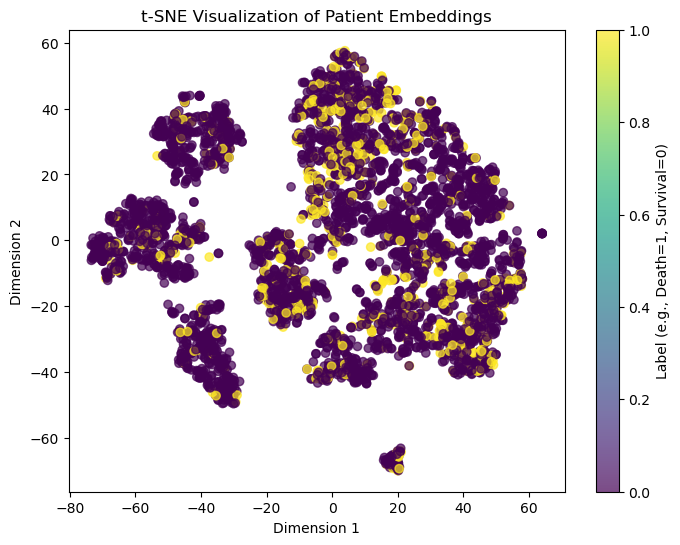

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Label (e.g., Death=1, Survival=0)')
plt.title("t-SNE Visualization of Patient Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

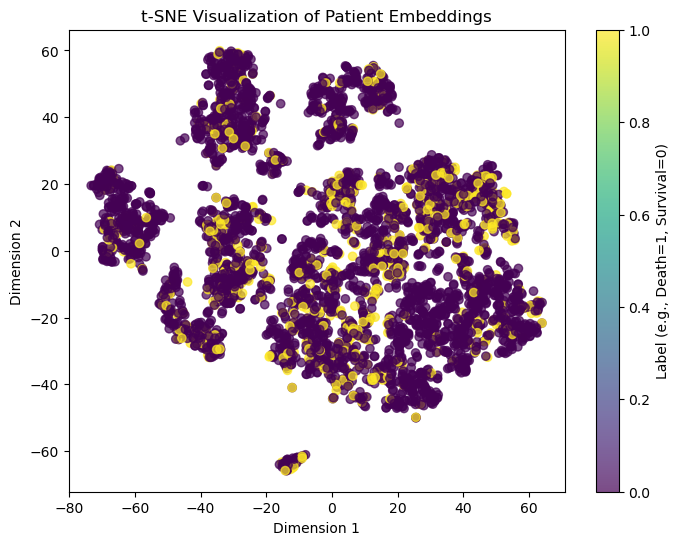

In [ ]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Label (e.g., Death=1, Survival=0)')
plt.title("t-SNE Visualization of Patient Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [20]:
from sklearn.metrics import silhouette_score

# embeddings_2d: your 2D t-SNE or UMAP embeddings
# labels: corresponding class labels for each data point
sil_score = silhouette_score(embeddings, labels)
print("Silhouette Score:", sil_score)

Silhouette Score: -0.0012001476
